##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Overview

This colab walks you through the basics of using TensorFlow GAN (TF-GAN) on Tensor Processing Units (TPUs).

It assumes that you are familiar with GAN concepts.

### TPUs

TPUs are chips optimized for machine learning training and inference. GAN training uses a lot of compute power, so TPUs expand the range of what we can realistically accomplish with GANs.

### CIFAR10 Task

In this colab we'll use TPUs to train a GAN for a more difficult task than the MNIST task tackled in the [GANEstimator](https://goto.google.com/tfgan-tutorial) colab. We'll use the [CIFAR10](https://wikipedia.org/wiki/CIFAR-10) dataset to train a model to generate images of airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

The training runs for 50000 steps and completes in roughly 10 minutes on TPUs.

### DCGAN Architecture

Our model implements the Deep Convolutional Generative Adversarial Network (DCGAN) architecture. [Convolutional Neural Networks](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNNs) are a common machine learning technique for dealing with images. DCGAN adapts a CNN architecture so that it can function as part of a GAN.

## Learning objectives

In this Colab, you will learn how to:
*   Build a simple DCGAN generator and discriminator
*   Use a TPUGANEstimator from TF-GAN to train on CIFAR10 data.
*   Run the model forward and see how well it generates images.


## Instructions

<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

In [0]:
import tensorflow as tf
import pprint

with tf.Session() as session:
  devices = session.list_devices()
pprint.pprint(devices)
device_is_tpu = [True if 'TPU' in str(x) else False for x in devices]
assert True in device_is_tpu, 'Did you forget to switch to TPU?'

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, -1, 15376538823509660050),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11801894177827567415),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9560029855720394814),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4557882769266023019),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 17179869184, 719446759948101480),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 17179869184, 12084276822845982378),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 17179869184, 4748198698827558589),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 17179869184, 5126934796736956825),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 17179869184, 15496843670698206354),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU

## Train and evaluate a GAN model on TPU using TF-GAN.


We define the same basic pieces for our GAN that we defined in the [GANEstimator](https://goto.google.com/tfgan-tutorial-v2) colab:

*   Input pipeline
*   Neural net architecture with generator and discriminator networks
*   Estimator
*   Train and eval loop



### Input Pipeline

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  
  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random_normal([bs, nd])))

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('cifar10', split=split)
               .map(_preprocess, num_parallel_calls=4)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))


def noise_input_fn(params, deterministic=True):
  if deterministic:
    np.random.seed(0)
  np_noise = np.random.randn(params['batch_size'], params['noise_dims'])
  return tf.data.Dataset.from_tensors(tf.constant(np_noise, dtype=tf.float32))

Sanity check the inputs.

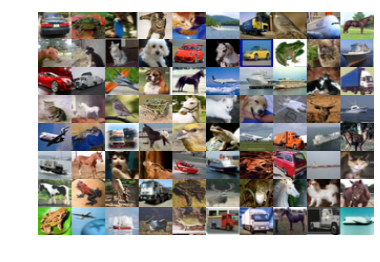

In [0]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
import tensorflow_gan as tfgan

params = {'batch_size': 80, 'noise_dims':64}
ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
numpy_imgs = tfds.as_numpy(ds).next()[1]
image_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(8, 10))

def _show_image_grid(image_grid):
  plt.axis('off')
  plt.imshow((image_grid + 1.0) / 2.0,  # [-1, 1] -> [0, 1]
             aspect='auto')
  plt.show()
_show_image_grid(image_grid)

### Neural Net Architecture

As usual, our GAN has two separate networks:

*  A generator that takes input noise and outputs images
*  A discriminator that takes images and outputs a probability of being real

We define `discriminator()` and `generator()` builder functions that assemble these networks, along with several helper functions that build pieces of these networks. In the "Estimator" section below we pass the `discriminator()` and `generator()` functions to the `TPUGANEstimator`

In [0]:
def _leaky_relu(x):
  return tf.nn.leaky_relu(x, alpha=0.2)


def _batch_norm(x, is_training, name):
  return tf.layers.batch_normalization(
      x, momentum=0.9, epsilon=1e-5, training=is_training, name=name)


def _dense(x, channels, name):
  return tf.layers.dense(
      x, channels,
      kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
      name=name)


def _conv2d(x, filters, kernel_size, stride, name):
  return tf.layers.conv2d(
      x, filters, [kernel_size, kernel_size],
      strides=[stride, stride], padding='same',
      kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
      name=name)


def _deconv2d(x, filters, kernel_size, stride, name):
  return tf.layers.conv2d_transpose(
      x, filters, [kernel_size, kernel_size],
      strides=[stride, stride], padding='same',
      kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
      name=name)


def discriminator(images, unused_conditioning, is_training=True,
                  scope='Discriminator'):
  images.shape.assert_is_compatible_with([None, None, None, 3])
  with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
    x = _conv2d(images, 64, 5, 2, name='d_conv1')
    x = _leaky_relu(x)

    x = _conv2d(x, 128, 5, 2, name='d_conv2')
    x = _leaky_relu(_batch_norm(x, is_training, name='d_bn2'))

    x = _conv2d(x, 256, 5, 2, name='d_conv3')
    x = _leaky_relu(_batch_norm(x, is_training, name='d_bn3'))

    x = tf.reshape(x, [-1, 4 * 4 * 256])

    x = _dense(x, 1, name='d_fc_4')

    return x


def generator(noise, is_training=True, scope='Generator'):
  noise.shape.assert_has_rank(2)  # [batch size, noise dim].

  with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
    net = _dense(noise, 4096, name='g_fc1')
    net = tf.nn.relu(_batch_norm(net, is_training, name='g_bn1'))

    net = tf.reshape(net, [-1, 4, 4, 256])

    net = _deconv2d(net, 128, 5, 2, name='g_dconv2')
    net = tf.nn.relu(_batch_norm(net, is_training, name='g_bn2'))

    net = _deconv2d(net, 64, 4, 2, name='g_dconv3')
    net = tf.nn.relu(_batch_norm(net, is_training, name='g_bn3'))

    net = _deconv2d(net, 3, 4, 2, name='g_dconv4')
    net = tf.tanh(net)

    return net

### Eval Utilities

We evaluate the performance of our generator using two standard metrics based on a pretrained classifier: the `Inception Score` and the `Frechet Inception Distance`.



In [0]:
import tensorflow_hub as hub
import functools

eval_batch_size = 4000 #@param

def get_real_image_logits(num_images, classifier_model):
  """Returns an array with logits from real images and a CIFAR classifier."""
  ds = input_fn(tf.estimator.ModeKeys.TRAIN, 
                {'batch_size': eval_batch_size, 'noise_dims': 1})
  iterator = tf.data.make_one_shot_iterator(ds)
  _, real_images = iterator.get_next()
  real_logits = classifier_model(real_images)
  
  with tf.train.MonitoredSession() as sess:
    logits = sess.run(real_logits)
  return logits

def init_global_real_logits():
  """Initialize a global variable with classifier logits for real data."""
  # We can hold all the real logits in memory at once, since CIFAR10 isn't that
  # big. Be sure to calculate it only once.
  global real_logits
  try:
    real_logits is not None
  except NameError:
    tf.reset_default_graph()
    classifier_model = hub.Module("@tfgan/eval/cifar10_convnet/1")
    real_logits = get_real_image_logits(eval_batch_size, classifier_model)
  assert real_logits.shape == (eval_batch_size, 10)
  
  
def calculate_real_data_classifier_score():
  """Calculate the classifier score on real data logits."""
  global real_logits
  assert real_logits is not None
  classifier_score = tfgan.eval.classifier_score_from_logits(real_logits)
  with tf.train.MonitoredSession() as sess:
    cscore_real = sess.run(classifier_score)
  return cscore_real


def get_inception_score_and_fid(est):
  """Calculate our evaluation metrics."""
  global real_logits
  assert real_logits is not None
  
  tf.reset_default_graph()
  classifier_model = hub.Module("@tfgan/eval/cifar10_convnet/1")

  predict_fn = functools.partial(noise_input_fn, deterministic=False)
  predictions = np.array(
        [x['generated_data'] for x in est.predict(predict_fn)])
  assert predictions.shape == (eval_batch_size, 32, 32, 3)
  fake_logits = classifier_model(predictions)
  fake_logits.shape.assert_is_compatible_with([eval_batch_size, 10])
  
  classifier_score = tfgan.eval.classifier_score_from_logits(fake_logits)
  fid = tfgan.eval.frechet_classifier_distance_from_activations(
      real_logits, fake_logits)
  
  with tf.train.MonitoredSession() as sess:
    cscore_np, fid_np = sess.run([classifier_score, fid])
  
  return cscore_np, fid_np
    

### Estimator

TF-GAN's `TPUGANEstimator` is like `GANEstimator`, but it extends TensorFlow's `TPUEstimator` class. `TPUEstimator` handles the details of deploying the network on a TPU.

In [0]:
import tensorflow as tf
import tensorflow_gan as tfgan

noise_dims = 256 #@param
generator_lr = 0.0002  #@param
discriminator_lr = 0.0002  #@param
train_batch_size = 1024  #@param

config = tf.contrib.tpu.RunConfig(
    tpu_config=tf.contrib.tpu.TPUConfig(iterations_per_loop=100))
est = tfgan.estimator.TPUGANEstimator(
    generator_fn=generator,
    discriminator_fn=discriminator,
    generator_loss_fn=tfgan.losses.modified_generator_loss,
    discriminator_loss_fn=tfgan.losses.modified_discriminator_loss,
    generator_optimizer=tf.train.AdamOptimizer(generator_lr, 0.5),
    discriminator_optimizer=tf.train.AdamOptimizer(discriminator_lr, 0.5),
    joint_train=True,  # train G and D jointly instead of sequentially.
    train_batch_size=train_batch_size,
    predict_batch_size=eval_batch_size,
    use_tpu=True,
    params={'noise_dims': noise_dims},
    config=config)

### Train and Eval Loop

Train, eval, and vizualize.

This loop should run at roughly **120 steps per second**, which is about **122K examples per second**. It should complete in roughly **10 minutes**.

Initialized classifier logits for real data.
Calculated classifier score for real data.
Current step: 5000, 151.7912 steps / sec, time since start: 0.9 min
Classifier score: 3.22 / 7.41, FID: 35.2, time to calculate eval: 23.91 sec


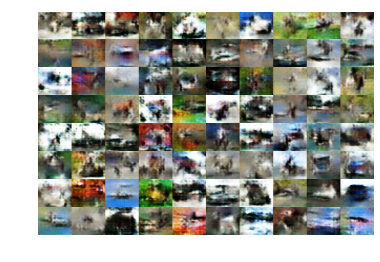

Current step: 10000, 143.3483 steps / sec, time since start: 2.0 min
Classifier score: 3.59 / 7.41, FID: 17.3, time to calculate eval: 20.51 sec


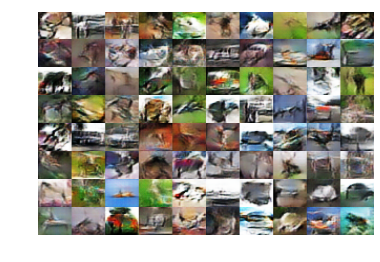

Current step: 15000, 141.1941 steps / sec, time since start: 3.1 min
Classifier score: 3.72 / 7.41, FID: 13.4, time to calculate eval: 22.60 sec


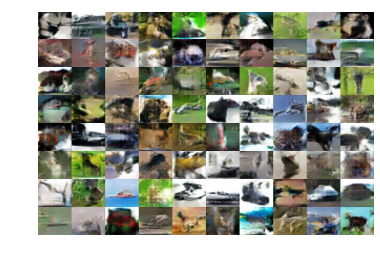

Current step: 20000, 143.9070 steps / sec, time since start: 4.2 min
Classifier score: 3.72 / 7.41, FID: 11.0, time to calculate eval: 22.42 sec


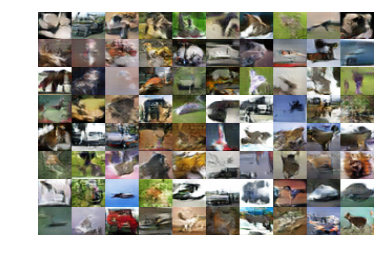

Current step: 25000, 143.0659 steps / sec, time since start: 5.3 min
Classifier score: 4.07 / 7.41, FID: 7.4, time to calculate eval: 25.82 sec


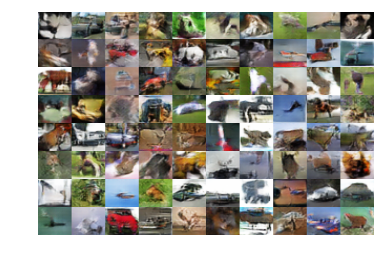

Current step: 30000, 147.4691 steps / sec, time since start: 6.5 min
Classifier score: 3.93 / 7.41, FID: 8.1, time to calculate eval: 23.95 sec


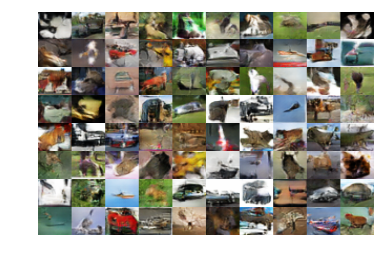

Current step: 35000, 147.1919 steps / sec, time since start: 7.6 min
Classifier score: 3.89 / 7.41, FID: 8.0, time to calculate eval: 19.19 sec


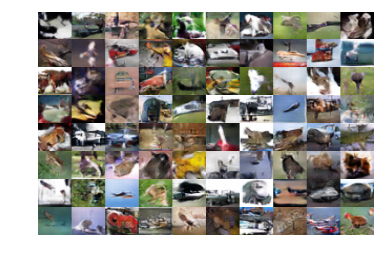

Current step: 40000, 145.0555 steps / sec, time since start: 8.6 min
Classifier score: 4.03 / 7.41, FID: 7.1, time to calculate eval: 24.37 sec


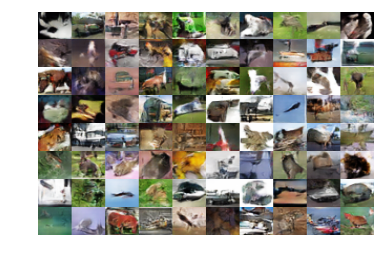

Current step: 45000, 144.8259 steps / sec, time since start: 9.8 min
Classifier score: 4.09 / 7.41, FID: 7.1, time to calculate eval: 19.66 sec


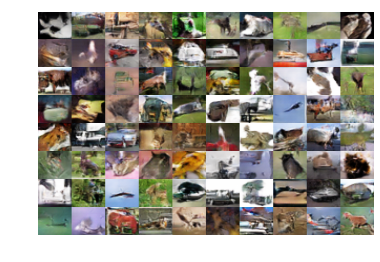

Current step: 50000, 146.0723 steps / sec, time since start: 10.8 min
Classifier score: 4.12 / 7.41, FID: 6.6, time to calculate eval: 22.25 sec


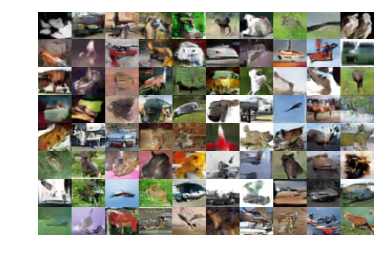

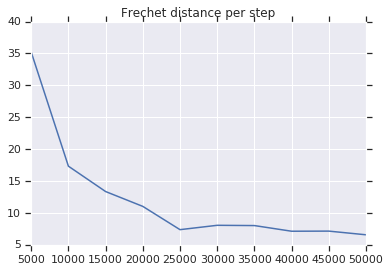

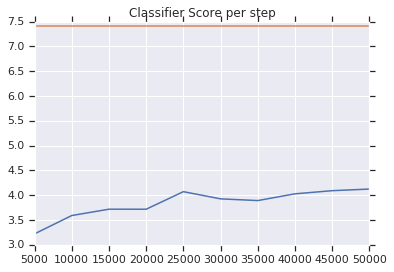

In [0]:
import time
import matplotlib.pyplot as plt

max_steps = 50000 #@param
eval_and_output_image_every = 5000 #@param

cur_step = 0
start_time = time.time()
cscores, fids, steps = [], [], []
init_global_real_logits()
print('Initialized classifier logits for real data.')
classifier_score_real_data = calculate_real_data_classifier_score()
print('Calculated classifier score for real data.')
while cur_step < max_steps:
  # Train for a fixed number of steps.
  start_step = cur_step
  step_to_stop_at = min(cur_step + eval_and_output_image_every, max_steps)
  start = time.time()
  est.train(input_fn, max_steps=step_to_stop_at)
  end = time.time()
  cur_step = step_to_stop_at
  
  # Print some performance statistics.
  steps_taken = step_to_stop_at - start_step
  time_taken = end - start
  steps_per_sec = steps_taken / time_taken
  min_since_start = (time.time() - start_time) / 60.0
  print("Current step: %i, %.4f steps / sec, time since start: %.1f min" % (
      cur_step, steps_per_sec, min_since_start))
  
  # Calculate some evaluation metrics.
  eval_start_time = time.time()
  cscore, fid = get_inception_score_and_fid(est)
  eval_time = (time.time() - eval_start_time)
  cscores.append(cscore)
  fids.append(fid)
  steps.append(cur_step)
  print("Classifier score: %.2f / %.2f, FID: %.1f, "
        "time to calculate eval: %.2f sec" % (
            cscore, classifier_score_real_data, fid, eval_time))
  
  # Generate and show some predictions.
  predictions = np.array(
      [x['generated_data'] for x in est.predict(noise_input_fn)])[:80]
  image_grid = tfgan.eval.python_image_grid(predictions, grid_shape=(8, 10))
  _show_image_grid(image_grid)
  
# Plot the metrics vs step.
plt.title('Frechet distance per step')
plt.plot(steps, fids)
plt.figure()
plt.title('Classifier Score per step')
plt.plot(steps, cscores)
plt.plot(steps, [classifier_score_real_data] * len(steps))
plt.figure()

## What's next

* Learn about [Cloud TPUs](https://cloud.google.com/tpu/docs) that Google designed and optimized specifically to speed up and scale up ML workloads for training and inference and to enable ML engineers and researchers to iterate more quickly.
* Explore the range of [Cloud TPU tutorials and Colabs](https://cloud.google.com/tpu/docs/tutorials) to find other examples that can be used when implementing your ML project.

On Google Cloud Platform, in addition to GPUs and TPUs available on pre-configured [deep learning VMs](https://cloud.google.com/deep-learning-vm/),  you will find [AutoML](https://cloud.google.com/automl/)*(beta)* for training custom models without writing code and [Cloud ML Engine](https://cloud.google.com/ml-engine/docs/) which will allows you to run parallel trainings and hyperparameter tuning of your custom models on powerful distributed hardware.
